# Main SS analysis development



In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from processor.SS_analysis import *
from Tools.config_helpers import *
from klepto.archives import dir_archive

In [ ]:
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [78]:
# the equivalent code can be run with ipython -i SS_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small
from processor.std_acumulators import desired_output, add_processes_to_output

overwrite = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'SS_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

year = 2018

fileset = {
    #'inclusive': glob.glob('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/inclusive_1000.root'),
    #'plus': glob.glob('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/plus_2000.root'),
    #'topW_v2': fileset_2018['topW_v2'], # verified that v2 and v3 are similar, v3 has more stats!
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    #'TTW': fileset_2018['TTW'],
    #'TTZ': fileset_2018['TTZ'],
    #'TTH': fileset_2018['TTH'],
    #'ttbar': fileset_2018['ttbar'][:12],
    #'ttbar1l': fileset_2018['ttbar1l'][:5],
    #'ttbar2l': fileset_2018['ttbar2l'][:5],
}


add_processes_to_output(fileset, desired_output)

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        SS_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()




In [71]:
def getChannel(histogram, n_ele=0):
    '''
    gets you just the ee/emu/mumu channel of each histogram by requiring 0-2 electrons
    '''
    bins_n_ele  = hist.Bin('n_ele', r'$N_{e}$', 1, n_ele-0.5, n_ele+0.5)
    tmp = histogram.copy()
    tmp = tmp.rebin('n_ele', bins_n_ele)
    tmp = tmp.sum('n_ele')
    #tmp = tmp.copy().project("dataset",axis)
    #nEvents = tmp.sum("dataset").values(overflow='over')[()].sum()
    #print ("Total number of events for signal point: %s"%nEvents)
    return tmp

In [41]:
getChannel(output['chargeFlip_vs_nonprompt'], n_ele=1).values()

{('ttbar2l',): array([[0.54289828, 1.32560503, 0.08074167, 0.        ],
        [1.7934777 , 0.29214419, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 ('ttbar1l',): array([[ 0.91038302, 14.85033475,  0.        ,  0.        ],
        [ 0.        ,  1.76290029,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]])}

In [37]:
output['chargeFlip_vs_nonprompt'].sum('n_ele').values()

{('ttbar2l',): array([[0.66461717, 2.84140666, 0.08074167, 0.        ],
        [2.92356645, 0.44128586, 0.        , 0.        ],
        [0.        , 0.07532913, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 ('ttbar1l',): array([[ 2.38471042, 30.44452793,  0.        ,  0.        ],
        [ 0.        ,  1.95539681,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]])}

Text(0, 0.5, '$N_{nonprompt}$')

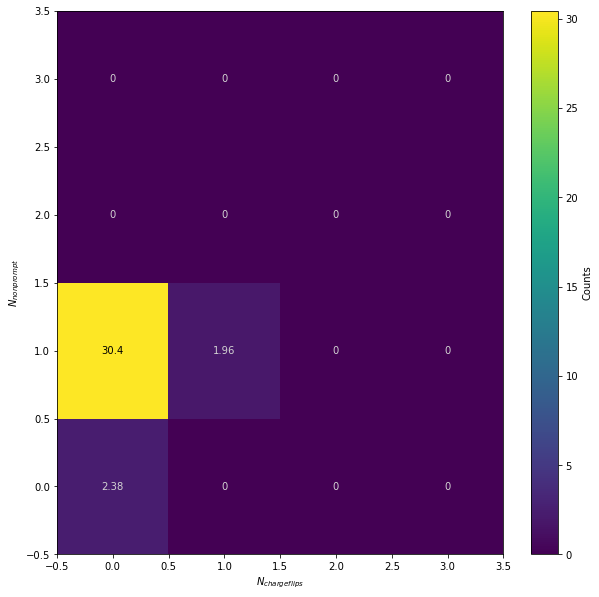

In [47]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(1,1,figsize=(10,10) )
ax = hist.plot2d(
    output['chargeFlip_vs_nonprompt']['ttbar1l'].sum('n_ele').sum('dataset'),
    xaxis='n1',
    ax=ax,
    text_opts={'format': '%.3g'},
    patch_opts={},
)
ax.set_xlabel(r'$N_{charge flips}$')
ax.set_ylabel(r'$N_{nonprompt}$')

Text(0, 0.5, '$N_{nonprompt}$')

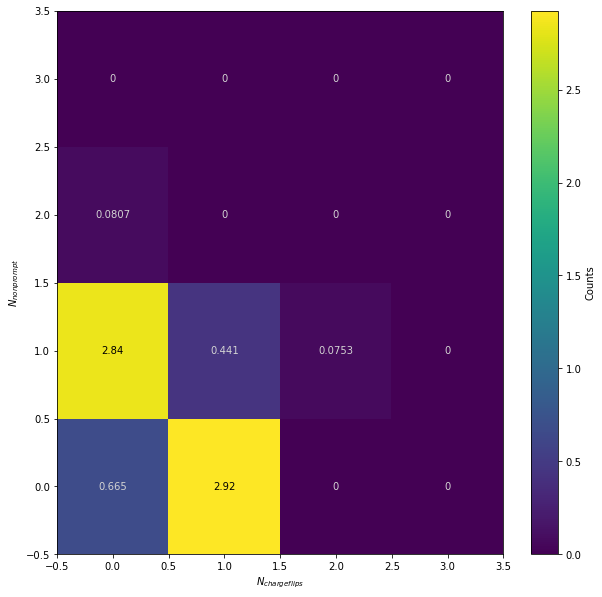

In [48]:
fig, ax  = plt.subplots(1,1,figsize=(10,10) )
ax = hist.plot2d(
    output['chargeFlip_vs_nonprompt']['ttbar2l'].sum('n_ele').sum('dataset'),
    xaxis='n1',
    ax=ax,
    text_opts={'format': '%.3g'},
    patch_opts={},
)
ax.set_xlabel(r'$N_{charge flips}$')
ax.set_ylabel(r'$N_{nonprompt}$')

In [73]:
from Tools.helpers import getCutFlowTable

processes = [
    #"inclusive", "plus",
    #'topW_v2',
    'topW_v3',
    'topW_EFT_cp8', 'topW_EFT_mix',
    #'TTW', 'TTZ', 'TTH', 'ttbar',
]
lines = ['entry']
lines += ['lepveto', 'dilep', 'SS', 'filter', 'p_T(lep0)>30', 'p_T(lep1)>20', 'trigger']
lines += ['N_jet>3', 'N_central>2', 'N_btag>0', 'N_fwd>0', 'N_jet>4', 'N_central>3', 'ST', 'MET>50', 'delta_eta', 'fwd_p>500', 'p_T(lep0)>40', 'p_T(lep1)>30']
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df


,topW_v3,topW_EFT_cp8,topW_EFT_mix,S/B
entry,226.4 +/- 0.2,3000.0 +/- 7.0,2449.0 +/- 6.0,0.0415
lepveto,119.7 +/- 0.2,694.3 +/- 3.3,560.1 +/- 3.0,0.0954
dilep,45.77 +/- 0.11,242.2 +/- 1.9,192.0 +/- 1.8,0.1054
SS,34.68 +/- 0.09,80.88 +/- 1.11,62.76 +/- 1.02,0.2414
filter,34.64 +/- 0.09,80.78 +/- 1.11,62.66 +/- 1.01,0.2415
p_T(lep0)>30,33.57 +/- 0.09,79.14 +/- 1.1,61.33 +/- 1.0,0.2390
p_T(lep1)>20,30.9 +/- 0.09,73.74 +/- 1.06,57.01 +/- 0.97,0.2363
trigger,27.47 +/- 0.08,66.56 +/- 1.01,51.41 +/- 0.92,0.2329
N_jet>3,24.61 +/- 0.08,60.06 +/- 0.95,44.38 +/- 0.84,0.2357
N_central>2,23.95 +/- 0.08,58.72 +/- 0.94,43.53 +/- 0.83,0.2343


In [11]:
ak.sum(test, axis=1)

<Array [6, 9, 0, 6] type='4 * int64'>

In [59]:
fileset_2018['topW_v3']

['/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_1.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_2.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_3.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_1.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_2.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_3.root']

In [67]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,topW_EFT_cp8,topW_EFT_mix
entry,1.0000,1.0000,1.0000
lepveto,0.5287,0.2315,0.2287
dilep,0.3824,0.3488,0.3427
SS,0.7578,0.3340,0.3269
filter,0.9990,0.9987,0.9984
p_T(lep0)>30,0.9691,0.9798,0.9788
p_T(lep1)>20,0.9203,0.9317,0.9295
trigger,0.8854,0.8998,0.8983
N_jet>3,0.8958,0.9022,0.8633
N_central>2,0.9731,0.9776,0.9807


In [12]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot
import re

bkgonly = re.compile('(?!(MuonEG))')

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'tW_scattering': 'top-W scat.',
    'topW_v2': 'top-W scat.',
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'SMEFT cp=8',
    'topW_EFT_mix': 'SMEFT mix',
}

my_colors = {
    'tW_scattering': '#FF595E',
    'topW_v2': '#FF595E',
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#525B76',
    'topW_EFT_mix': '#6A4C93',
}

Data: 0 MC: 46.41
Data: 0 MC: 46.41


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


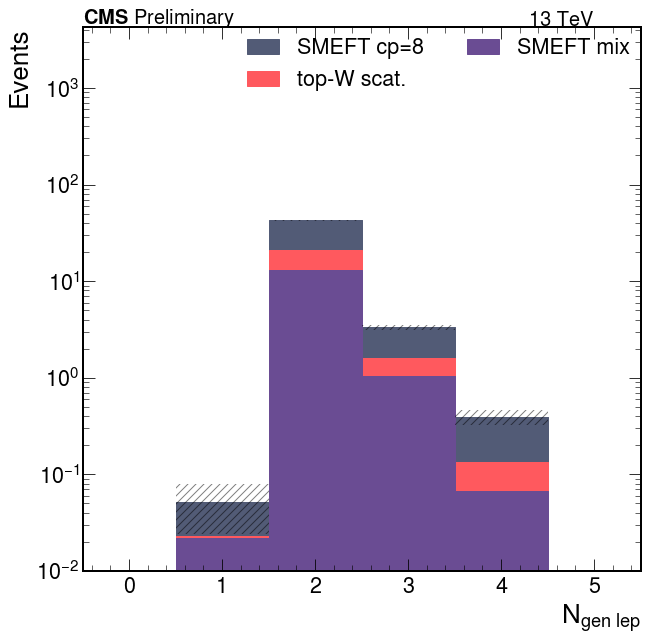

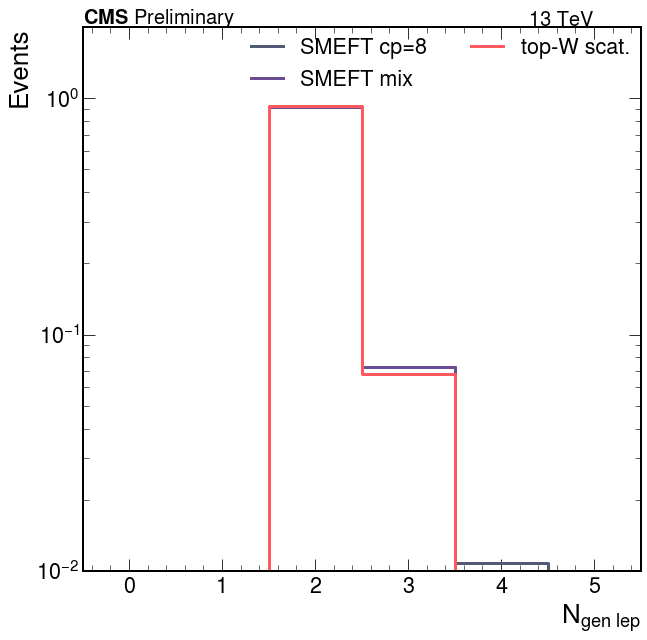

In [7]:
makePlot(output, 'nGenL', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ lep}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )
makePlot(output, 'nGenL', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ lep}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


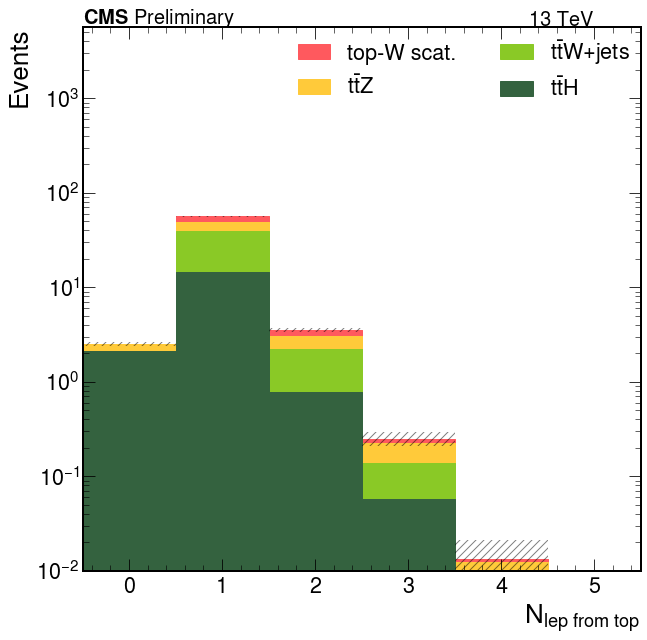

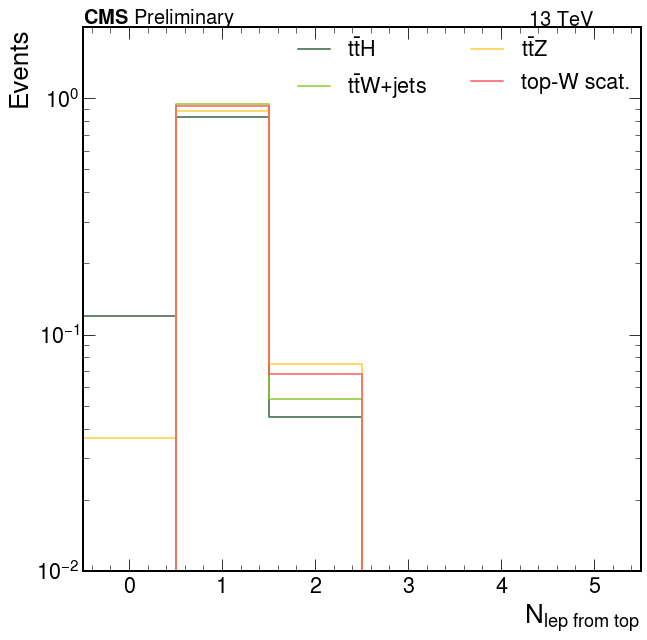

In [39]:
makePlot(output, 'nLepFromTop', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ top}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromTop', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ top}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


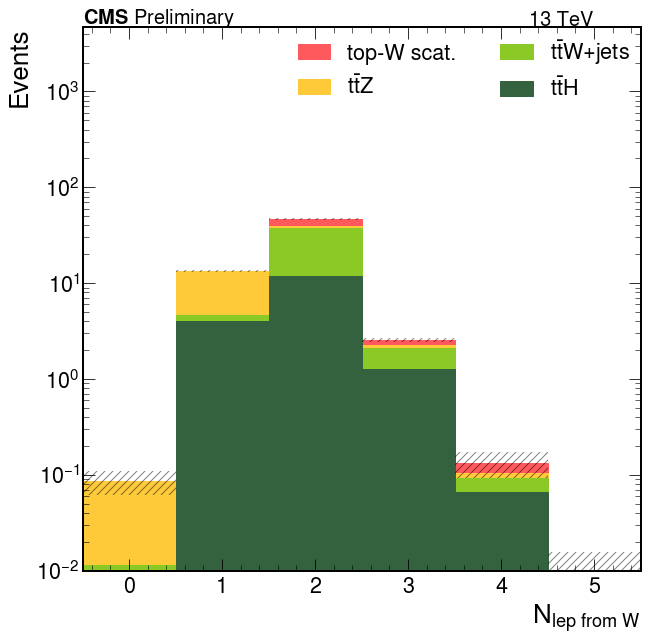

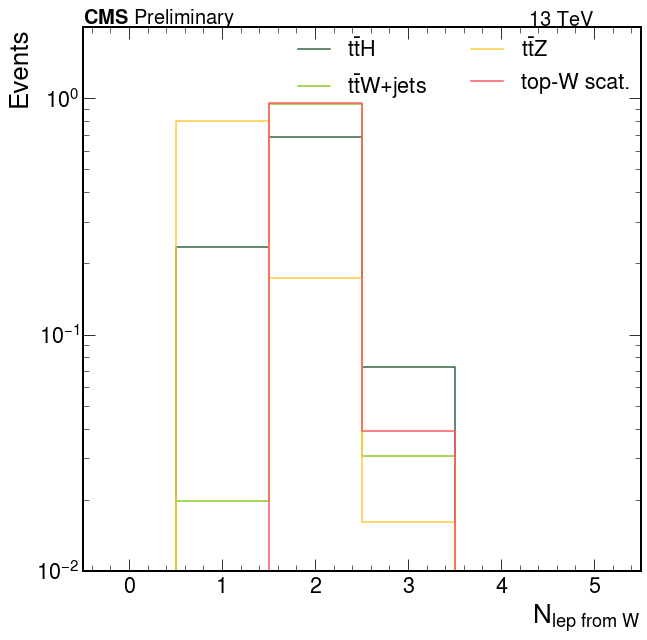

In [40]:
makePlot(output, 'nLepFromW', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ W}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromW', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ W}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


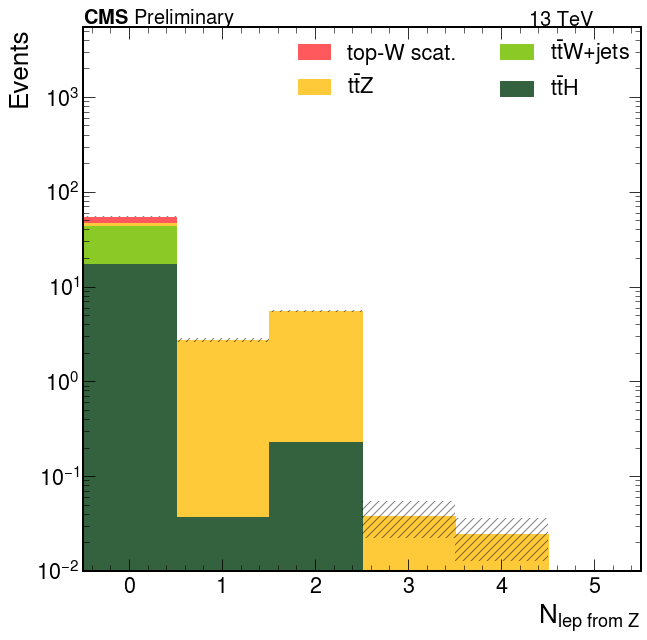

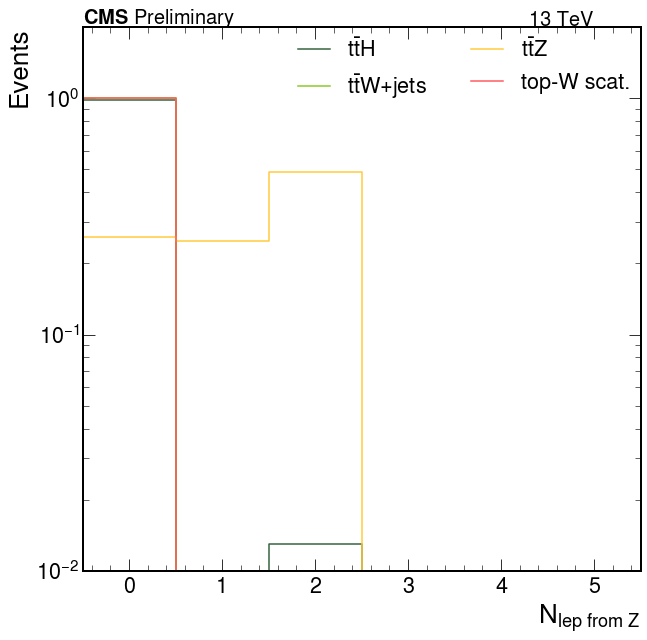

In [41]:
makePlot(output, 'nLepFromZ', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ Z}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromZ', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ Z}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


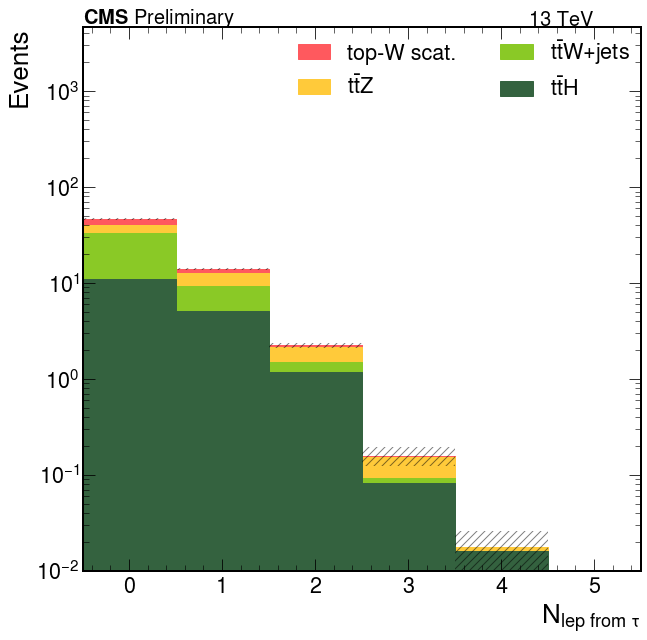

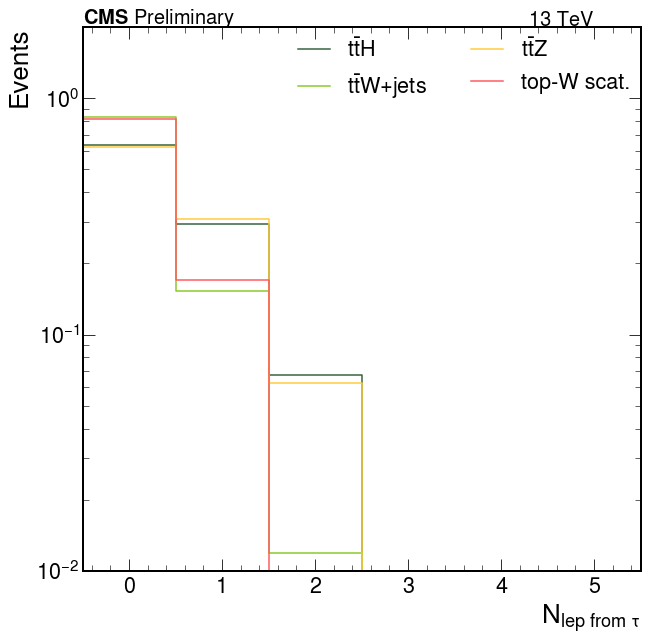

In [43]:
makePlot(output, 'nLepFromTau', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromTau', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


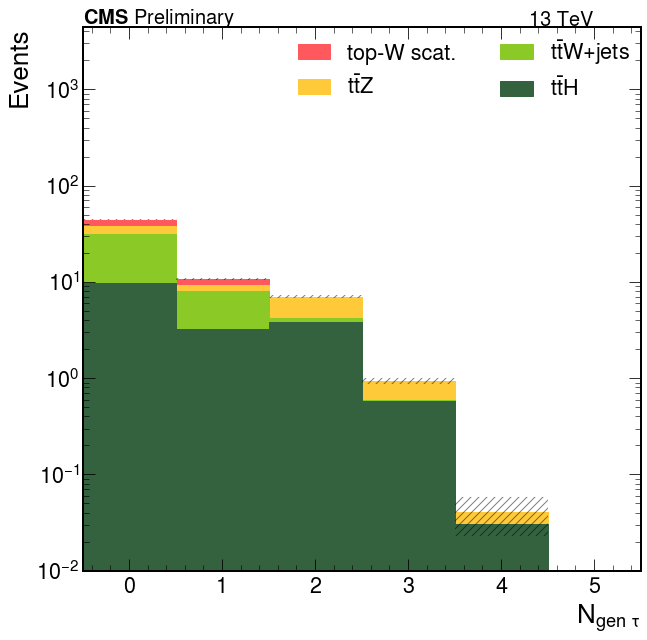

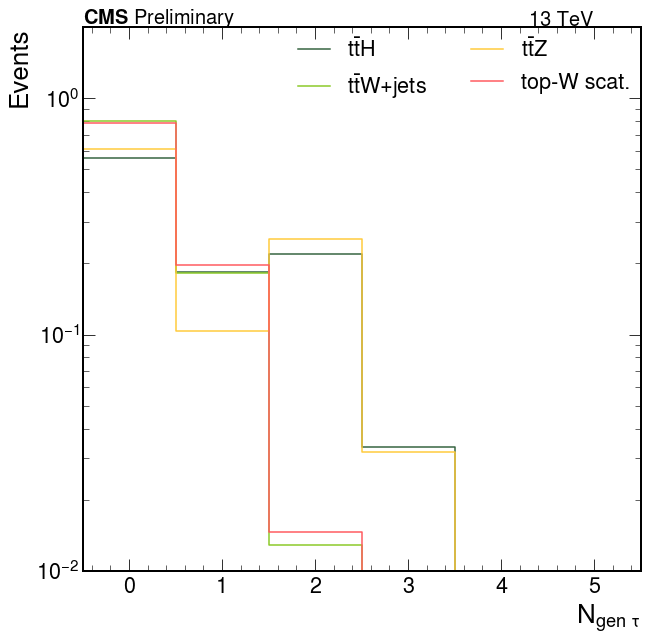

In [44]:
makePlot(output, 'nGenTau', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nGenTau', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 46.41
Data: 0 MC: 46.41


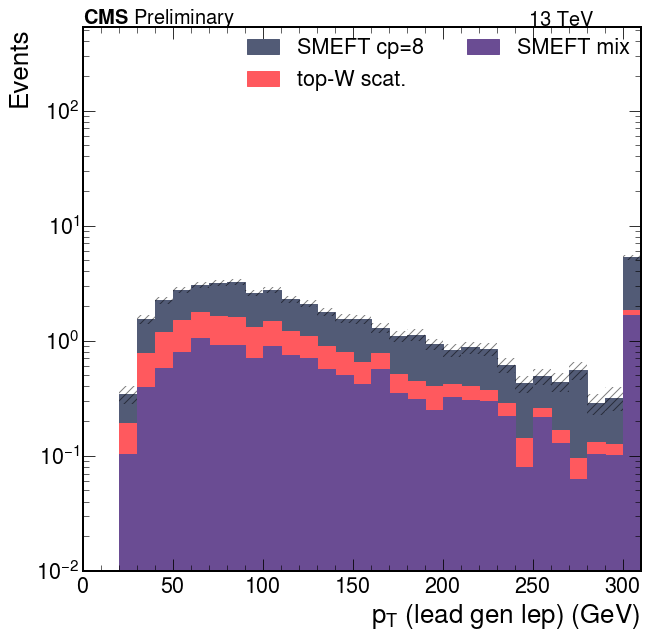

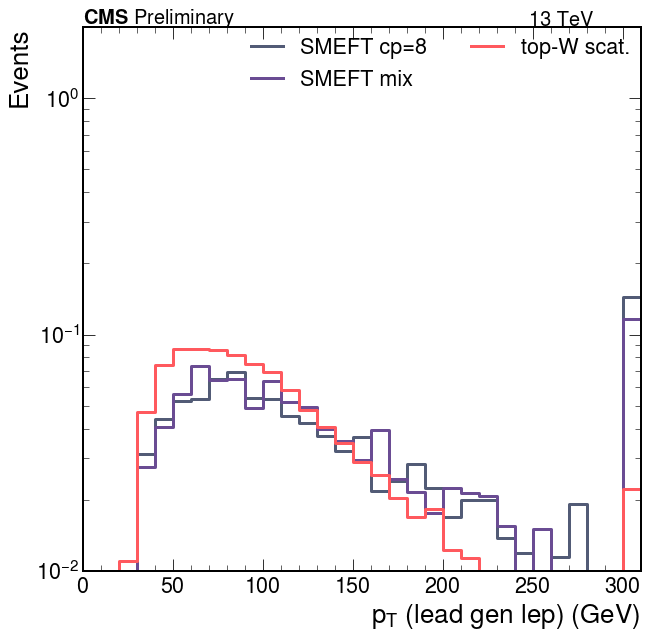

In [11]:
makePlot(output, 'lead_gen_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )
makePlot(output, 'lead_gen_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 46.99
Data: 0 MC: 46.99


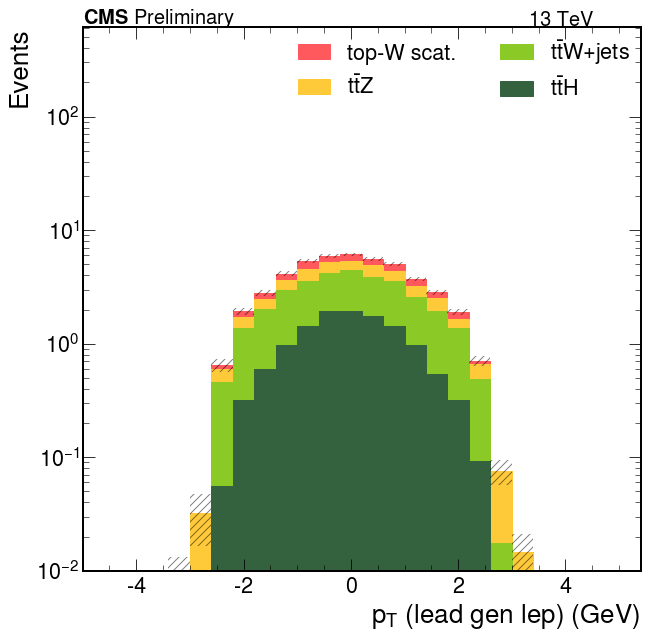

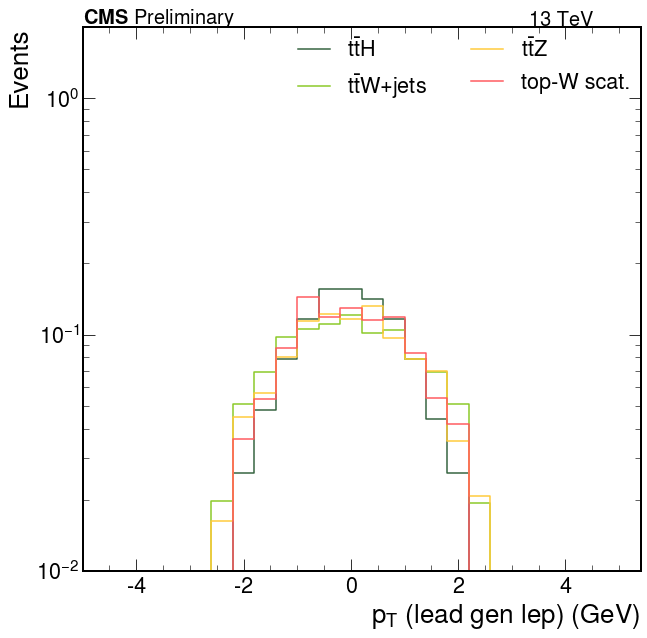

In [86]:
makePlot(output, 'lead_gen_lep', 'eta',
         data_sel=None,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'lead_gen_lep', 'eta',
         data_sel=None,
         shape=True,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.74
Data: 0 MC: 62.74


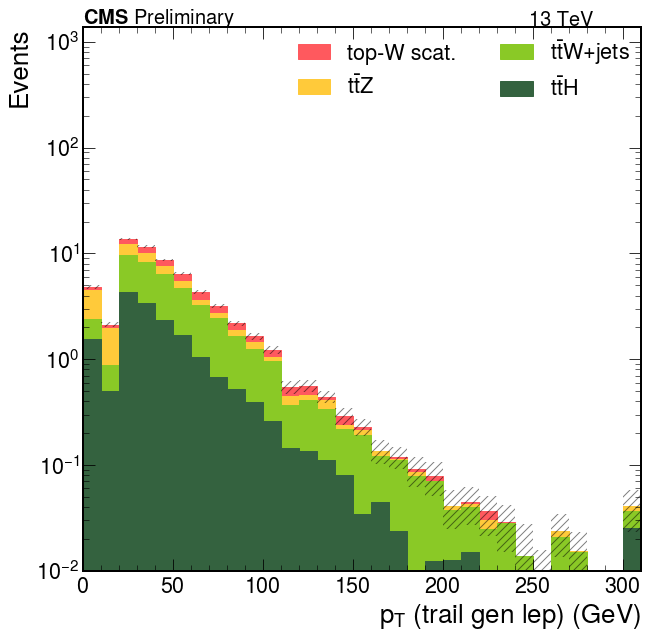

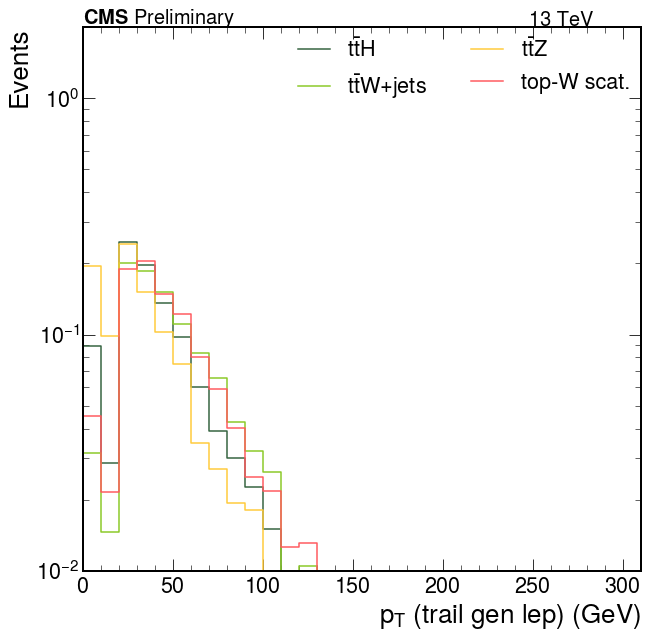

In [69]:
makePlot(output, 'trail_gen_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'trail_gen_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 46.97
Data: 0 MC: 46.97


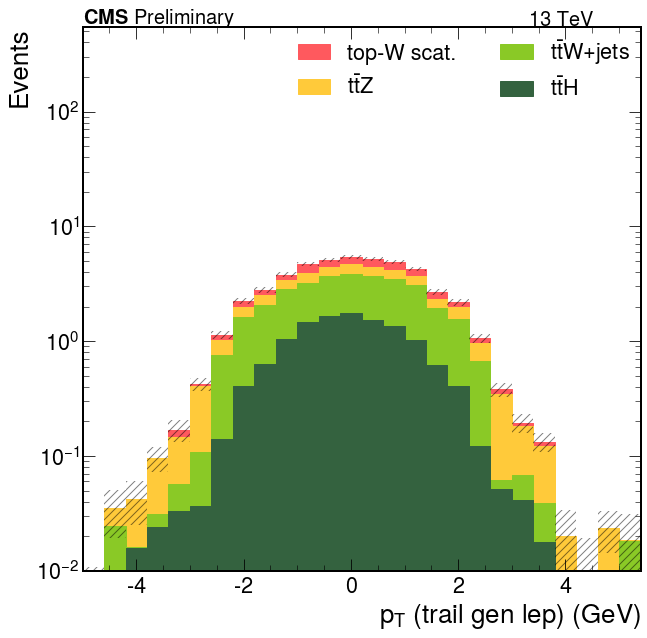

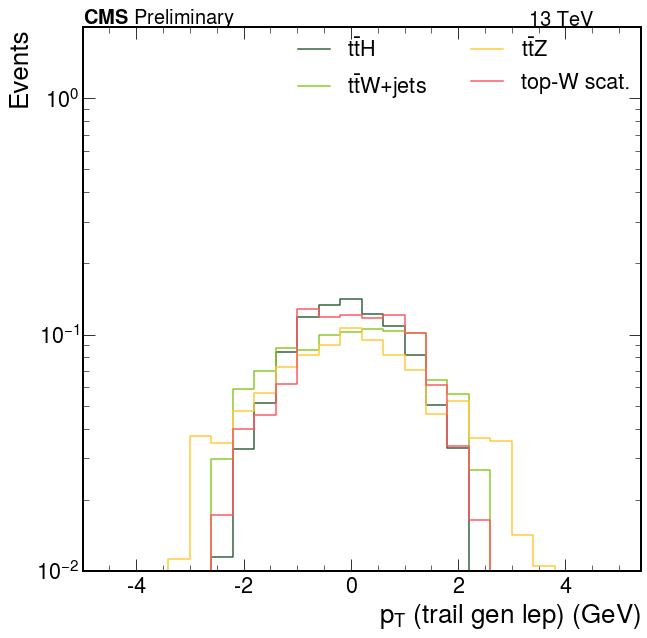

In [85]:
makePlot(output, 'trail_gen_lep', 'eta',
         data_sel=None,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'trail_gen_lep', 'eta',
         data_sel=None,
         shape=True,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 46.41
Data: 0 MC: 46.41


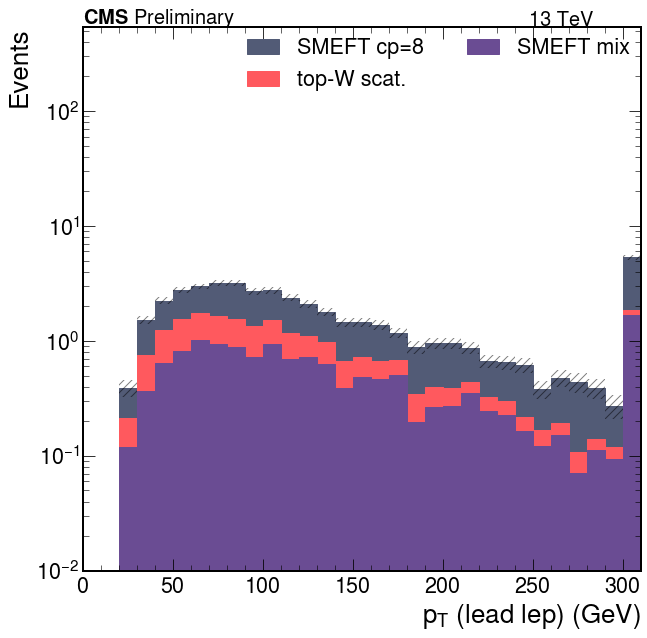

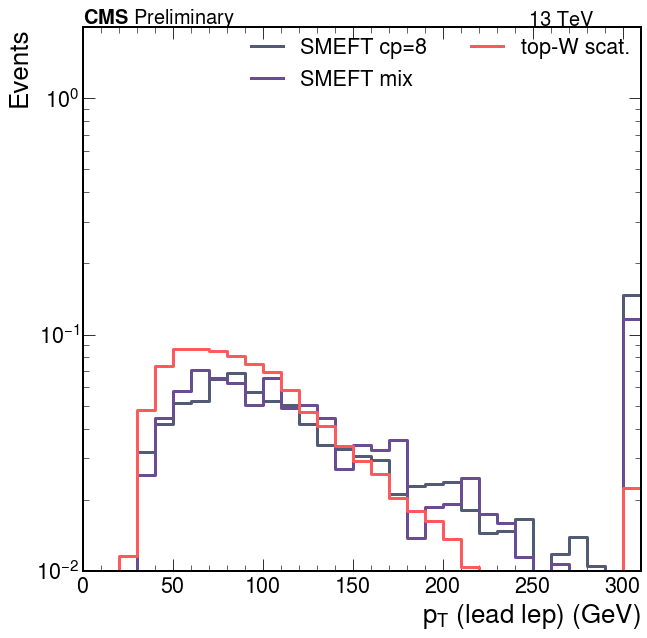

In [12]:
makePlot(output, 'lead_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )
makePlot(output, 'lead_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 46.41
Data: 0 MC: 46.41


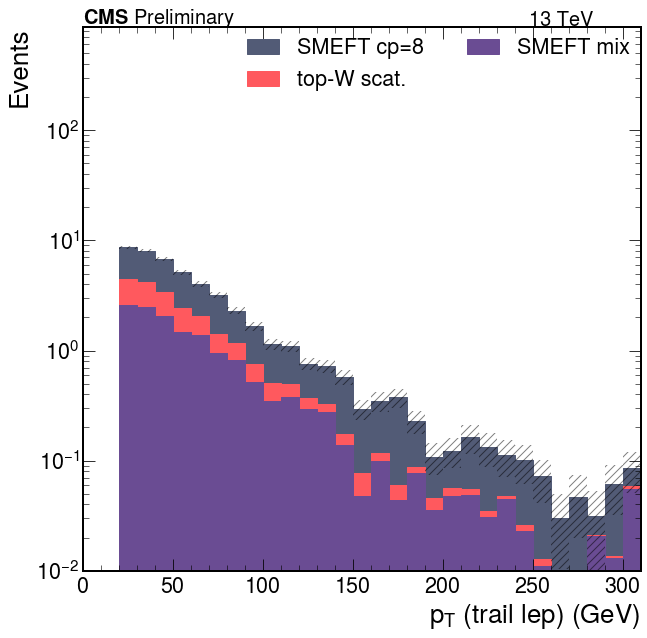

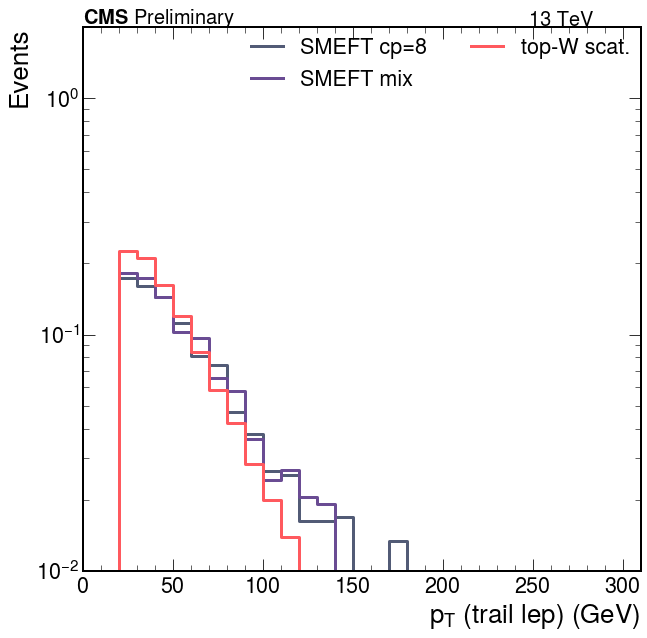

In [13]:
makePlot(output, 'trail_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )
makePlot(output, 'trail_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 46.41
Data: 0 MC: 46.41


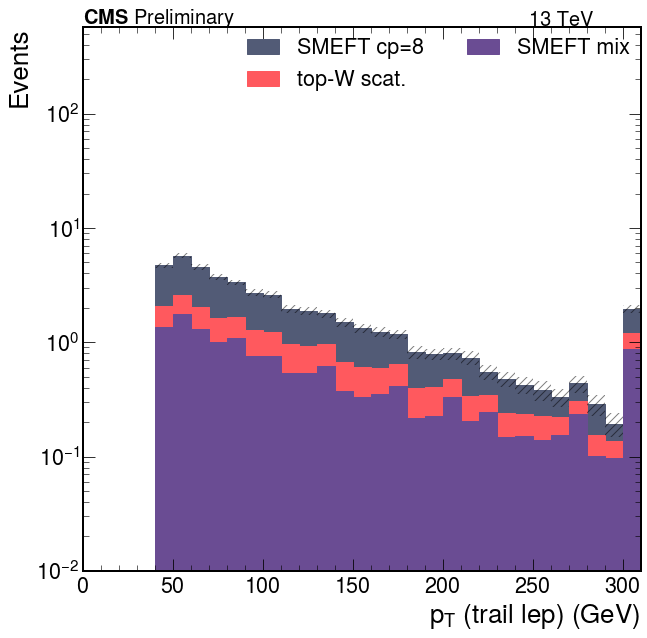

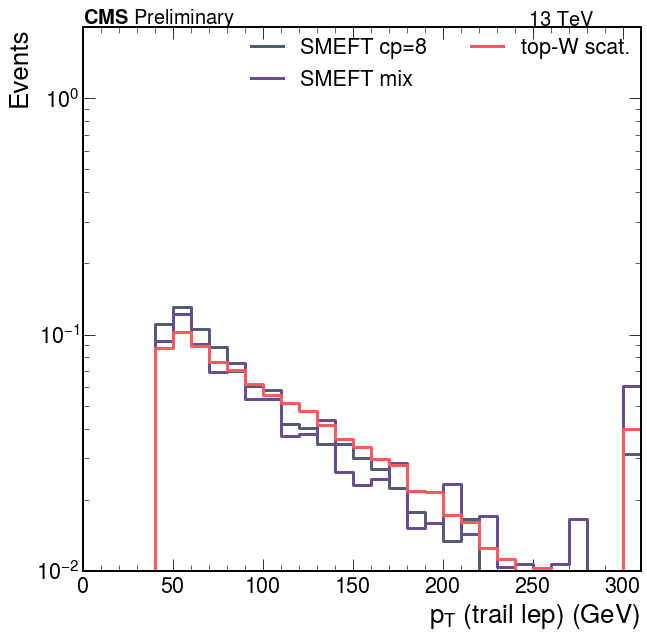

In [8]:
makePlot(output, 'fwd_jet', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )
makePlot(output, 'fwd_jet', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 46.41


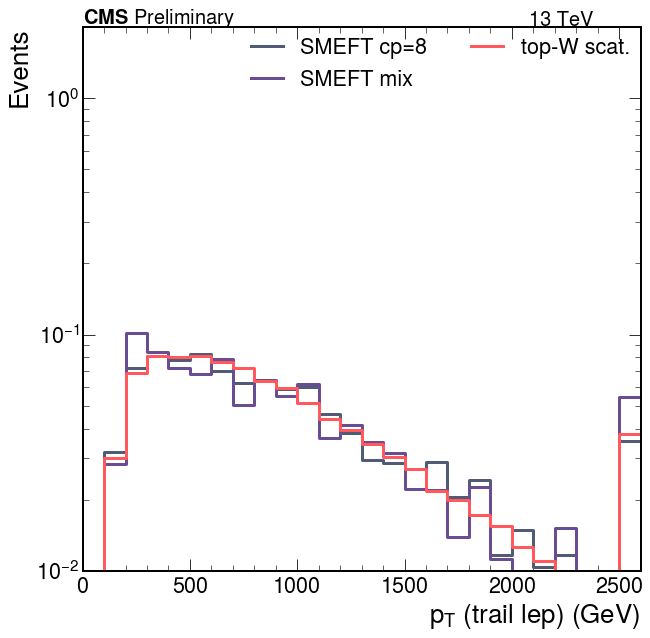

In [11]:
p_bins = hist.Bin('p', r'$p_{T}\ (GeV)$', 25, 0, 2500)

makePlot(output, 'high_p_fwd_p', 'p',
         data_sel=None,
         shape=True,
         bins=p_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

Data: 0 MC: 128.69


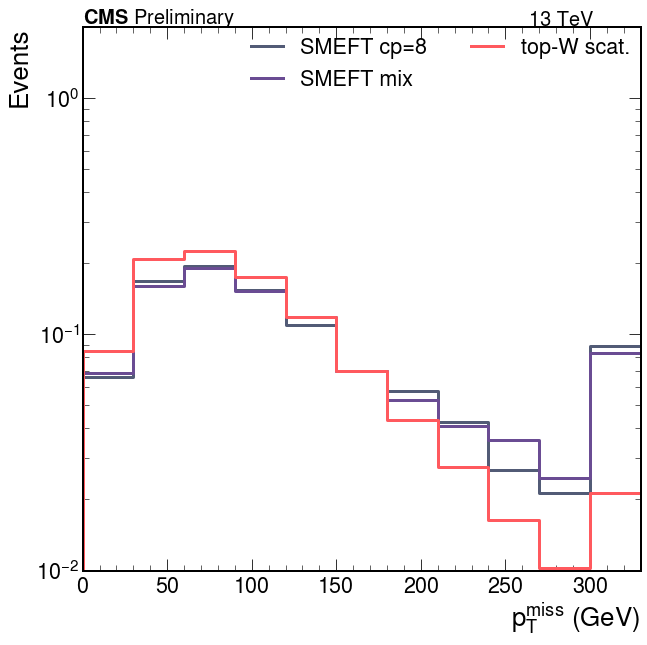

In [15]:
makePlot(output, 'MET', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}^{miss}$ (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown'],
         new_colors=my_colors, new_labels=my_labels,
        )

In [18]:
import uproot
fin = uproot.open('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/inclusive_1000.root')

In [19]:
tree = fin["Events"]

In [20]:
tree.Array("genWeight")

AttributeError: 'Model_TTree_v20' object has no attribute 'Array'

In [ ]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

# the below command will change to .from_root in coffea v0.7.0
events_incl = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/nanoAOD_1.root', schemaclass=NanoAODSchema).events()

from Tools.objects import *

sum_weight = sum(events_incl.genWeight)
sum_weight

In [34]:
sum(events_incl[((ak.num(muon)+ak.num(electron))==2)].genWeight)/sum_weight

0.036093418259023353

In [50]:
events_plus = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoAOD_1.root', schemaclass=NanoAODSchema).events()

sum_weight = sum(events_plus.genWeight)
sum_weight

7.205300881527364

In [10]:
from Tools.basic_objects import *

In [15]:
jet = getJets(events_incl)
fwd = getFwdJet(jet)

In [22]:
lead_fwd = ak.pad_none(fwd, 1, clip=True)
ak.flatten(lead_fwd)

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='1000 * ?jet'>

In [26]:
ak.flatten(ak.pad_none(jet, 1, clip=True))

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='1000 * ?jet'>

In [30]:
ak.pad_none(jet, 1, clip=True)[(ak.num(fwd)==0)]

<JetArray [[Jet], [Jet], ... [Jet], [Jet]] type='230 * 1 * ?jet'>

In [23]:
ak.flatten(lead_fwd) + ak.flatten((ak.num(fwd)==0)*ak.pad_none(jet, 1, clip=True))

ValueError: cannot broadcast: <class 'awkward._ext.NumpyArray'>, <class 'awkward._ext.RecordArray'>

(https://github.com/scikit-hep/awkward-1.0/blob/1.0.2/src/awkward/_util.py#L906)

In [38]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

# the below command will change to .from_root in coffea v0.7.0
events_incl = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/nanoAOD_1.root', schemaclass=NanoAODSchema)
from Tools.selection import Selection

In [39]:
ev = events_incl.events()

In [41]:
ev.HLT.Ele15_Ele8_CaloIdL_TrackIdL_IsoVL

<Array [False, True, False, ... False, False] type='1000 * bool[parameters={"__d...'>

ModuleNotFoundError: No module named 'Tools.selection'

In [34]:
import uproot
tree = uproot.open('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWJetsToLNuEWK_5f_EFT_mix_myNLO_full_RunIIAutumn18_NANO_v4//nanoSkim_1.root')

In [35]:
tree['Events'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nElectron            | uint32_t                 | AsDtype('>u4')
Electron_deltaEtaSC  | float[]                  | AsJagged(AsDtype('>f4'))
Electron_dxy         | float[]                  | AsJagged(AsDtype('>f4'))
Electron_dz          | float[]                  | AsJagged(AsDtype('>f4'))
Electron_eCorr       | float[]                  | AsJagged(AsDtype('>f4'))
Electron_eInvMinu... | float[]                  | AsJagged(AsDtype('>f4'))
Electron_energyErr   | float[]                  | AsJagged(AsDtype('>f4'))
Electron_eta         | float[]                  | AsJagged(AsDtype('>f4'))
Electron_hoe         | float[]                  | AsJ

In [36]:
ev = tree['Events']

In [37]:
[ b.name for b in ev.branches ]

['run',
 'luminosityBlock',
 'event',
 'nElectron',
 'Electron_deltaEtaSC',
 'Electron_dxy',
 'Electron_dz',
 'Electron_eCorr',
 'Electron_eInvMinusPInv',
 'Electron_energyErr',
 'Electron_eta',
 'Electron_hoe',
 'Electron_ip3d',
 'Electron_jetPtRelv2',
 'Electron_jetRelIso',
 'Electron_mass',
 'Electron_miniPFRelIso_all',
 'Electron_mvaFall17V1noIso',
 'Electron_mvaFall17V2noIso',
 'Electron_pfRelIso03_all',
 'Electron_phi',
 'Electron_pt',
 'Electron_sieie',
 'Electron_sip3d',
 'Electron_mvaTTH',
 'Electron_charge',
 'Electron_cutBased',
 'Electron_jetIdx',
 'Electron_pdgId',
 'Electron_tightCharge',
 'Electron_convVeto',
 'Electron_lostHits',
 'Electron_mvaFall17V2noIso_WP80',
 'Electron_mvaFall17V2noIso_WPL',
 'Flag_ecalBadCalibFilterV2',
 'nFatJet',
 'FatJet_btagDeepB',
 'FatJet_deepTagMD_TvsQCD',
 'FatJet_deepTagMD_WvsQCD',
 'FatJet_eta',
 'FatJet_mass',
 'FatJet_phi',
 'FatJet_pt',
 'nGenJet',
 'GenJet_eta',
 'GenJet_mass',
 'GenJet_phi',
 'GenJet_pt',
 'nGenPart',
 'GenPart_eta